# DVCLive and Lightning Fabric

## Install dvclive

In [ ]:
!pip install "dvclive[lightning]"

## Initialize DVC Repository

In [ ]:
!git init -q
!git config --local user.email "you@example.com"
!git config --local user.name "Your Name"
!dvc init -q
!git commit -m "DVC init"

## Imports

In [1]:
import argparse
from os import path
from types import SimpleNamespace

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
from lightning.fabric import Fabric, seed_everything
from lightning.fabric.utilities.rank_zero import rank_zero_only
from torch.optim.lr_scheduler import StepLR
from torchmetrics.classification import Accuracy
from torchvision.datasets import MNIST

from dvclive.fabric import DVCLiveLogger

DATASETS_PATH = ("Datasets")

/Users/dave/micromamba/envs/dvc/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Setup model code

Adapted from https://github.com/Lightning-AI/pytorch-lightning/blob/master/examples/fabric/image_classifier/train_fabric.py.

Look for the `logger` statements where DVCLiveLogger calls were added.

In [2]:
class Net(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


def run(hparams):
    # Create the DVCLive Logger
    logger = DVCLiveLogger(report="notebook")

    # Log dict of hyperparameters
    logger.log_hyperparams(hparams.__dict__)

    # Create the Lightning Fabric object. The parameters like accelerator, strategy, devices etc. will be proided
    # by the command line. See all options: `lightning run model --help`
    fabric = Fabric()

    seed_everything(hparams.seed)  # instead of torch.manual_seed(...)

    transform = T.Compose([T.ToTensor(), T.Normalize((0.1307,), (0.3081,))])

    # Let rank 0 download the data first, then everyone will load MNIST
    with fabric.rank_zero_first(local=False):  # set `local=True` if your filesystem is not shared between machines
        train_dataset = MNIST(DATASETS_PATH, download=fabric.is_global_zero, train=True, transform=transform)
        test_dataset = MNIST(DATASETS_PATH, download=fabric.is_global_zero, train=False, transform=transform)

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=hparams.batch_size,
    )
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=hparams.batch_size)

    # don't forget to call `setup_dataloaders` to prepare for dataloaders for distributed training.
    train_loader, test_loader = fabric.setup_dataloaders(train_loader, test_loader)

    model = Net()  # remove call to .to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=hparams.lr)

    # don't forget to call `setup` to prepare for model / optimizer for distributed training.
    # the model is moved automatically to the right device.
    model, optimizer = fabric.setup(model, optimizer)

    scheduler = StepLR(optimizer, step_size=1, gamma=hparams.gamma)

    # use torchmetrics instead of manually computing the accuracy
    test_acc = Accuracy(task="multiclass", num_classes=10).to(fabric.device)

    # EPOCH LOOP
    for epoch in range(1, hparams.epochs + 1):
        # TRAINING LOOP
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # NOTE: no need to call `.to(device)` on the data, target
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            fabric.backward(loss)  # instead of loss.backward()

            optimizer.step()
            if (batch_idx == 0) or ((batch_idx + 1) % hparams.log_interval == 0):
                print(
                    "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                        epoch,
                        batch_idx * len(data),
                        len(train_loader.dataset),
                        100.0 * batch_idx / len(train_loader),
                        loss.item(),
                    )
                )

                # Log dict of metrics
                logger.log_metrics({"loss": loss.item()})

                if hparams.dry_run:
                    break

        scheduler.step()

        # TESTING LOOP
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for data, target in test_loader:
                # NOTE: no need to call `.to(device)` on the data, target
                output = model(data)
                test_loss += F.nll_loss(output, target, reduction="sum").item()

                # WITHOUT TorchMetrics
                # pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                # correct += pred.eq(target.view_as(pred)).sum().item()

                # WITH TorchMetrics
                test_acc(output, target)

                if hparams.dry_run:
                    break

        # all_gather is used to aggregated the value across processes
        test_loss = fabric.all_gather(test_loss).sum() / len(test_loader.dataset)

        print(f"\nTest set: Average loss: {test_loss:.4f}, Accuracy: ({100 * test_acc.compute():.0f}%)\n")

        # log additional metrics
        logger.log_metrics({"test_loss": test_loss, "test_acc": 100 * test_acc.compute()})

        test_acc.reset()

        if hparams.dry_run:
            break

    # When using distributed training, use `fabric.save`
    # to ensure the current process is allowed to save a checkpoint
    if hparams.save_model:
        fabric.save("mnist_cnn.pt", model.state_dict())

        # `logger.experiment` provides access to the `dvclive.Live` instance where you can use additional logging methods.
        # Check that `rank_zero_only.rank == 0` to avoid logging in other processes.
        if rank_zero_only.rank == 0:
          logger.experiment.log_artifact("mnist_cnn.pt")

    # Call finalize to save final results as a DVC experiment
    logger.finalize("success")

## Train the model

# DVC Report

params.yaml

|   batch_size |   epochs |   lr |   gamma | dry_run   |   seed |   log_interval | save_model   |
|--------------|----------|------|---------|-----------|--------|----------------|--------------|
|           64 |        5 |    1 |     0.7 | False     |      1 |             10 | True         |

metrics.json

|       loss |   step |   test.loss |   test.acc |
|------------|--------|-------------|------------|
| 0.00467984 |    475 |   0.0297012 |      99.05 |

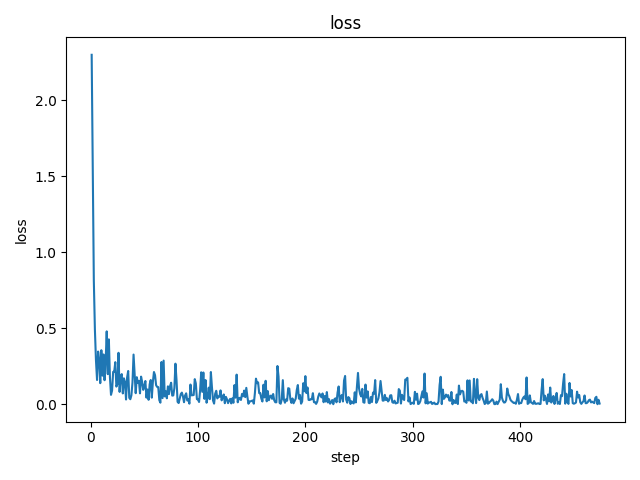

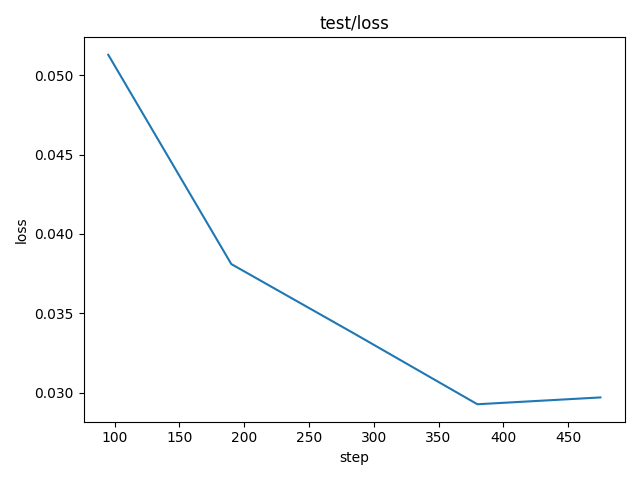

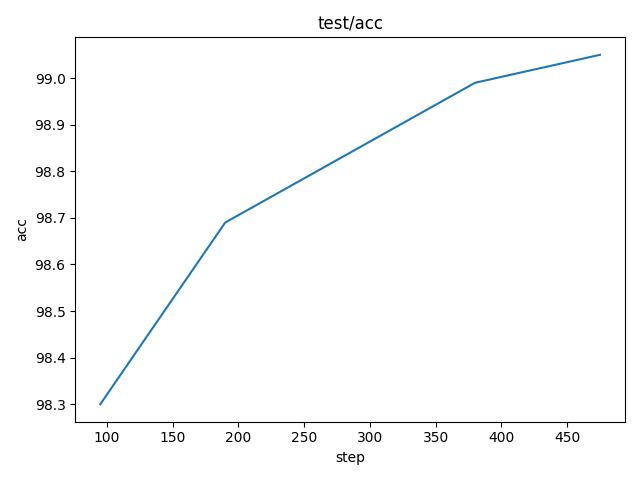


Seed set to 1


100%|██████████| 9912422/9912422 [00:00<00:00, 11345002.02it/s]


Extracting Datasets/MNIST/raw/train-images-idx3-ubyte.gz to Datasets/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 66086030.45it/s]


Extracting Datasets/MNIST/raw/train-labels-idx1-ubyte.gz to Datasets/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 9205122.52it/s]


Extracting Datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to Datasets/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17461529.58it/s]


Extracting Datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to Datasets/MNIST/raw

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.300024
Train Epoch: 1 [576/60000 (1%)]	Loss: 1.546772
Train Epoch: 1 [1216/60000 (2%)]	Loss: 0.815391
Train Epoch: 1 [1856/60000 (3%)]	Loss: 0.491915
Train Epoch: 1 [2496/60000 (4%)]	Loss: 0.288376
Train Epoch: 1 [3136/60000 (5%)]	Loss: 0.159752
Train Epoch: 1 [3776/60000 (6%)]	Loss: 0.346852
Train Epoch: 1 [4416/60000 (7%)]	Loss: 0.295374
Train Epoch: 1 [5056/60000 (8%)]	Loss: 0.138947
Train Epoch: 1 [5696/60000 (9%)]	Loss: 0.355745
Train Epoch: 1 [6336/60000 (11%)]	Loss: 0.188486
Train Epoch: 1 [6976/60000 (12%)]	Loss: 0.327759
Train Epoch: 1 [7616/60000 (13%)]	Loss: 0.158329
Train Epoch: 1 [8256/60000 (14%)]	Loss: 0.278104
Train Epoch: 1 [8896/60000 (15%)]	Loss: 0.479855
Train Epoch: 1 [9536/60000 (16%)]	Loss: 0.198383
Train Epoch: 1 [10176/60000 (17%)]	Loss: 0.427230
Train Epoch: 1 [10816/60000 (18%)]	Loss: 0.178351
Train Epoch: 1 [11456/60000 (19%)]	Loss: 0.062128
T

	examples/MNIST/MNIST/raw/t10k-images-idx3-ubyte, examples/MNIST/MNIST/raw/t10k-labels-idx1-ubyte, examples/MNIST/MNIST/raw/train-images-idx3-ubyte, examples/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz, examples/MNIST/MNIST/raw/train-images-idx3-ubyte.gz, examples/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz, examples/MNIST/MNIST/raw/train-labels-idx1-ubyte, examples/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz, examples/Datasets/MNIST/raw/t10k-images-idx3-ubyte, examples/Datasets/MNIST/raw/t10k-labels-idx1-ubyte, examples/Datasets/MNIST/raw/train-images-idx3-ubyte, examples/Datasets/MNIST/raw/t10k-images-idx3-ubyte.gz, examples/Datasets/MNIST/raw/train-images-idx3-ubyte.gz, examples/Datasets/MNIST/raw/train-labels-idx1-ubyte.gz, examples/Datasets/MNIST/raw/train-labels-idx1-ubyte, examples/Datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz


In [3]:
hparams = SimpleNamespace(batch_size=64, epochs=5, lr=1.0, gamma=0.7, dry_run=False, seed=1, log_interval=10, save_model=True)
run(hparams)